# Case study: Aecert Robotics gaits gen

Aecert Robotics youtube channel covers a hexapod build and it mentions a new gait generation algorithm that allows on the fly transitions https://youtu.be/DKsyJYkdZ_o?si=0ym37QSEdOcEfFBf

With some google search it looks like code is here https://github.com/Ryan-Mirch/Aecerts_Hexapod_V1/blob/main/RC_V3/RC%20Code/src/Pages/GaitsPage.cpp

There is no license attached in the repo, which means now work can be reproduced, distributed or any derivative work can be created... according to https://docs.github.com/en/repositories/managing-your-repositorys-settings-and-features/customizing-your-repository/licensing-a-repository code in public repo can be forked and viewed

This notebook is just a case study of the code in original repo and is not a derivative work. All copyright to the code still belongs to 

In [1]:
# For local development enable python modules live reloading
%load_ext autoreload
%autoreload 2

%matplotlib inline

Initializing...
Loading calibration data...
No calibration data found, using defaults
dict_keys(['straight_push', 'rotate_push', 'straight_lift', 'rotate_lift'])


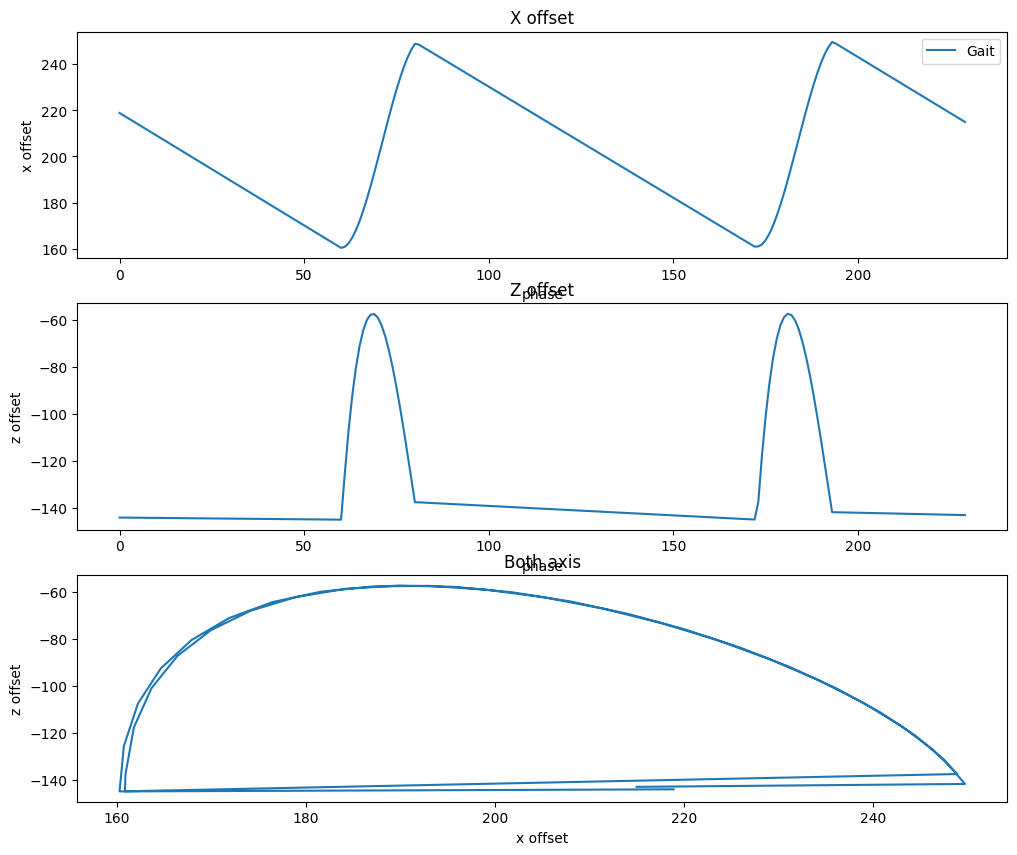

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#!./.venv/bin/python

from matplotlib import pyplot as plt
from globals import PRESSED, Gait, g, PackageType
from hexapod_initializations import setup_sim_legs, a1, a2, a3
from models import HexapodModel
from bezier import set_on_get_point_on_bezier_curve, Vector3
from typing import Literal

import hexapod_main
from nrf import rc_control_data

rc_control_data.gait = Gait.WAVE
hexapod_main.setup()

g.current_type = PackageType.RC_CONTROL_DATA
hexapod_main.loop()


def process_frame(delta_time=0.001):
    plt.show(block=False)
    plt.pause(delta_time)
g.process_frame = process_frame

control_points = [{} for _ in range(6)]
def on_get_point_on_bezier_curve(points: list[Vector3], t: float, result: Vector3, leg: Literal[0, 1, 2, 3, 4, 5], phase: Literal['rotate', 'straight'], state: Literal['lift', 'push'], **kwargs):
    leg_points = control_points[leg]
    item_name = phase + '_' + state

    if item_name not in leg_points:
        leg_points[item_name] = []
    leg_points[item_name] += [{
        'points': points,
        't': t,
        'result': result,
        'phase': phase,
        'state': state,
    }]

set_on_get_point_on_bezier_curve(on_get_point_on_bezier_curve)

hexapod = HexapodModel(
    coxa_len=a1,
    femur_len=a2,
    tibia_len=a3,
    front_offset=85,
    middle_offset=100,
    side_offset=55,
    leg_rotation=[0, 0, g.leg_placement_angle],
)
hexapod.forward_kinematics(0.0, 81.19264931247422, 137.66638455325148)

class MoveRecorder:
    def __init__(self, real_leg):
        self.real_leg = real_leg
        self.leg_positions = []
        self.leg_local_positions = []
        self.leg_rotations = []

    def forward_kinematics(self, alpha, beta, gamma):
        self.real_leg.forward_kinematics(alpha, beta, gamma)
        self.leg_rotations.append([alpha, beta, gamma])
        self.leg_positions.append(self.real_leg.tibia_end.numpy())

    def inverse_kinematics_local(self, foot_target):
        self.leg_local_positions.append(foot_target.numpy())
        return self.real_leg.inverse_kinematics_local(foot_target)

class DummyHexapod:
    def __init__(self):
        self.left_front = MoveRecorder(hexapod.left_front)
        self.left_middle = MoveRecorder(hexapod.left_middle)
        self.left_back = MoveRecorder(hexapod.left_back)
        self.right_front = MoveRecorder(hexapod.right_front)
        self.right_middle = MoveRecorder(hexapod.right_middle)
        self.right_back = MoveRecorder(hexapod.right_back)

        self.all_legs = [
            self.left_front,
            self.left_middle,
            self.left_back,
            self.right_front,
            self.right_middle,
            self.right_back,
        ]

recorder = DummyHexapod()
setup_sim_legs(recorder)

start_frame = 70
end_frame = 300
frame = 0
while frame <= end_frame:
    frame += 1

    if frame >= start_frame:
      g.current_type = PackageType.RC_CONTROL_DATA
      rc_control_data.joy1_Y = 80 # move forward

    hexapod_main.loop()
    g.process_frame(0.001)

fig, ax = plt.subplots(3, 1)
fig.set_size_inches((12, 10))

phase = np.arange(0, end_frame - start_frame)
gait_points = np.array(recorder.left_front.leg_positions)[start_frame:end_frame]
ax[0].set_xlabel('phase')
ax[0].set_ylabel('x offset')
ax[0].set_title('X offset')
ax[0].plot(phase, gait_points[:, 0], label='Gait')

ax[0].legend()

ax[1].set_xlabel('phase')
ax[1].set_ylabel('z offset')
ax[1].set_title('Z offset')
ax[1].plot(phase, gait_points[:, 2], label='Gait')

# plot both axis
ax[2].set_xlabel('x offset')
ax[2].set_ylabel('z offset')
ax[2].set_title('Both axis')
ax[2].plot(gait_points[:, 0], gait_points[:, 2], label='Gait')

In [ ]:
fig, ax = plt.subplots(2, 1)
fig.set_size_inches((12, 10))

phase = np.arange(0, end_frame - start_frame)


for leg in recorder.all_legs:
    gait_points = np.array(leg.leg_positions)[start_frame:end_frame]
    ax[0].plot(phase, gait_points[:, 0], label=leg.real_leg.label)
    ax[1].plot(phase, gait_points[:, 2], label=leg.real_leg.label)

ax[0].set_xlabel('phase')
ax[0].set_ylabel('x offset')
ax[0].set_title('X offset')
ax[0].legend()

ax[1].set_xlabel('phase')
ax[1].set_ylabel('z offset')
ax[1].set_title('Z offset')

fig, ax = plt.subplots(len(recorder.all_legs), 3)
fig.set_size_inches((12, 10))

for i, leg in enumerate(recorder.all_legs):
    ax[i][0].set_title(f'{leg.real_leg.label}')
    ax[i][0].set_ylabel('x')
    ax[i][1].set_ylabel('y')
    ax[i][2].set_ylabel('z')

    gait_points = np.array(leg.leg_positions)[start_frame:end_frame]
    ax[i][0].plot(phase, gait_points[:, 0])
    ax[i][1].plot(phase, gait_points[:, 1])
    ax[i][2].plot(phase, gait_points[:, 2])


straight_push[[ 201.   31. -145.]]
straight_lift[[ 201.   31.   11.]
 [ 145.  -25.  -75.]
 [ 138.  -32. -145.]]


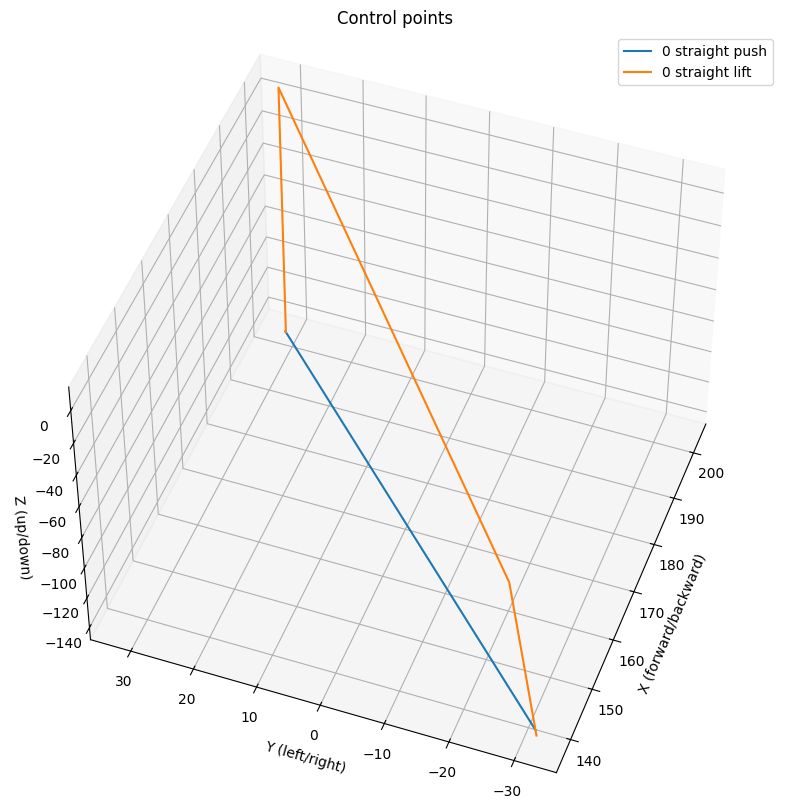

In [22]:
#  control_points[leg][phase + state] = (points, t, result)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

ax.view_init(elev=47, azim=-160)
# ax.view_init(elev=24, azim=24)

ax.set_title('Control points')
ax.set_xlabel('X (forward/backward)')
ax.set_ylabel('Y (left/right)')
ax.set_zlabel('Z (up/down)')

def vec3_to_np(vec3):
    return np.array([vec3.x, vec3.y, vec3.z])

def vec3_arr_to_np(arr):
    return np.array([vec3_to_np(v) for v in arr])

# for leg_id, points in enumerate(control_points):
#   # print(leg_id, points[0:2])
#   for point_group in points.values():
#     for point in point_group:
#       bezier_points = vec3_arr_to_np(point['points'])

#       bezier_t = point['t']
#       bezier_result = vec3_to_np(point['result'])
#       bezier_phase = point['phase']
#       bezier_state = point['state']

#       ax.plot(bezier_points[:, 0], bezier_points[:, 1], bezier_points[:, 2], label=f'{leg_id} {bezier_phase} {bezier_state}')

leg_id = 0
points_to_plot = {}
for name, point_group in control_points[leg_id].items():
    # print(name)
    for point in point_group:
      # print(point)
      bezier_points = vec3_arr_to_np(point['points'])

      points_key = name + str(np.floor(bezier_points[1:]))

      points_to_plot[points_key] = point

for points_key, point in points_to_plot.items():
      bezier_points = vec3_arr_to_np(point['points'])
      bezier_phase = point['phase']
      bezier_state = point['state']

      if bezier_phase == 'rotate':
        continue
      # if bezier_state == 'lift':
      #   continue

      print(points_key)
      ax.plot(bezier_points[:, 0], bezier_points[:, 1], bezier_points[:, 2], label=f'{leg_id} {bezier_phase} {bezier_state}')


ax.legend()